In [ ]:
import numpy as np
import pandas as pd
import string
import re
import os
from transformers import AutoModel
from transformers import AutoTokenizer

In [ ]:
!pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 33.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.0
    Uninstalling transformers-4.41.0:
      Successfully uninstalled transformers-4.41.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
suffix = 'drive/MyDrive/medical_dataset_analysis/'

beth_file_directory = 'concept_assertion_relation_training_data/beth/txt/'
beth_concept_directory = 'concept_assertion_relation_training_data/beth/concept/'

partner_file_directory = 'concept_assertion_relation_training_data/partners/txt/'
partner_concept_directory = 'concept_assertion_relation_training_data/partners/concept/'

test_directory = 'test_data/'
test_directory_concepts = 'reference_standard_for_test_data/concepts/'

In [ ]:
def getNotes(file_directory):
    text_dict = {}
    file_list = os.listdir(suffix+file_directory)
    for f in file_list:
        if f[-3:] != 'xml' and f[-3:] != 'txt' and f[-3:] != 'con':
            file_list.remove(f)
    if '.DS_Store' in file_list:
        file_list.remove('.DS_Store')
    for file_name in file_list:
        with open(suffix+file_directory + file_name,'r') as file:
            data = file.read()
            text_dict[file_name[:-4]] = data
        file.close()
    return text_dict

In [ ]:
beth_notes = getNotes(beth_file_directory)
beth_concepts = getNotes(beth_concept_directory)
partners_notes = getNotes(partner_file_directory)
partners_concepts = getNotes(partner_concept_directory)

In [ ]:
train_notes = beth_notes.copy()
train_notes.update(partners_notes)
all_notes = train_notes.copy()
train_records = list(train_notes.keys())

train_concepts = beth_concepts.copy()
train_concepts.update(partners_concepts)
all_concepts = train_concepts.copy()
train_concepts_records = list(train_concepts.keys())

test_notes = getNotes(test_directory)
test_notes_records = list(test_notes.keys())
test_concepts = getNotes(test_directory_concepts)
test_concepts_records = list(test_concepts.keys())

all_notes.update(test_notes)
all_concepts.update(test_concepts)

In [ ]:
beth_rel_directory = 'concept_assertion_relation_training_data/beth/rel/'
partner_rel_directory = 'concept_assertion_relation_training_data/partners/rel/'
test_directory_rel = 'reference_standard_for_test_data/rel/'

In [ ]:
beth_rel = getNotes(beth_rel_directory)
partners_rel = getNotes(partner_rel_directory)

train_rel = beth_rel.copy()
train_rel.update(partners_rel)
all_rel = train_rel.copy()
train_rel_records = list(train_rel.keys())

test_rel = getNotes(test_directory_rel)
test_rel_records = list(test_rel.keys())

In [ ]:
all_rel.update(test_rel)

In [ ]:
def get_tags(record):
  note = all_notes[record].split('\n')
  number_of_lines = len(note)

  all_note = []
  all_tag = []
  note_lines = [n.split() for n in note]
  tag_list = [['O' for j in i] for i in note_lines]

  concept_lines = all_concepts[record].split('\n')
  for i in concept_lines:
    if len(i) > 0:

      # print(i)
      c = re.findall(r'c=\".+"',i)
      stuff = re.findall('[0-9]{1,3}:[0-9]{1,3}\s[0-9]{1,3}:[0-9]{1,3}\|\|',i)[0]

      line = re.findall(r'[0-9]{1,3}:',stuff)
      line1 = int(line[0][:-1])
      line2 = int(line[1][:-1])

      indexes = re.findall(r':[0-9]{1,3}',stuff)
      ind1 = int(indexes[0][1:])
      ind2 = int(indexes[1][1:])

      t = re.findall(r't=\"[a-z]+\"',i)
      tag = t[0][3:-1]

      for line in range(line1,line2+1):
        for index in range(ind1,ind2+1):
          if line==line1 and index==ind1:
            tag_list[line-1][index] = 'B' + '-' + tag
          else:
            tag_list[line-1][index] = 'I' + '-' + tag

  for t in tag_list:
    for ti in t:
      all_tag.append(ti)

  for n in note_lines:
    for ni in n:
      all_note.append(ni)
  return all_note, all_tag

records_dict = {}
for record in all_notes.keys():
  note,tag = get_tags(record)
  the_dict = {'words':note,'tags':tag}
  records_dict[record] = the_dict

In [ ]:
def get_tags2(record):
  note = all_notes[record].split('\n')
  number_of_lines = len(note)

  all_note = []
  all_tag = []
  note_lines = [n.split() for n in note]
  tag_list = [['O' for j in i] for i in note_lines]
  try:
    rel_lines = all_rel[record].split('\n')
    for i in rel_lines:
      if len(i) > 0:

        # print(i)
        c = re.findall(r'c=\".+"',i)
        stuff = re.findall('[0-9]{1,3}:[0-9]{1,3}\s[0-9]{1,3}:[0-9]{1,3}\|\|',i)[0]
        # print(stuff)
        stuff2 = re.findall('[0-9]{1,3}:[0-9]{1,3}\s[0-9]{1,3}:[0-9]{1,3}$',i)[0]
        # print(stuff2)

        line = re.findall(r'[0-9]{1,3}:',stuff)
        line1 = int(line[0][:-1])
        line2 = int(line[1][:-1])
        # print(line)

        linex = re.findall(r'[0-9]{1,3}:',stuff2)
        line1x = int(linex[0][:-1])
        line2x = int(linex[1][:-1])
        # print(linex)

        indexes = re.findall(r':[0-9]{1,3}',stuff)
        ind1 = int(indexes[0][1:])
        ind2 = int(indexes[1][1:])
        # print(indexes)

        indexesx = re.findall(r':[0-9]{1,3}',stuff2)
        ind1x = int(indexesx[0][1:])
        ind2x = int(indexesx[1][1:])
        # print(indexesx)

        r = re.findall(r'r=\"[A-Za-z]+\"',i)
        tag = r[0][3:-1]

        for line in range(line1,line2+1):
          for index in range(ind1,ind2+1):
            if line==line1 and index==ind1:
              tag_list[line-1][index] = 'B' + '-' + tag
            else:
              tag_list[line-1][index] = 'I' + '-' + tag

        for line in range(line1x,line2x+1):
          for index in range(ind1x,ind2x+1):
            if line==line1x and index==ind1x:
              tag_list[line-1][index] = 'B' + '-' + tag
            else:
              tag_list[line-1][index] = 'I' + '-' + tag

  except KeyError:
    pass

  for r in tag_list:
    for ri in r:
      all_tag.append(ri)

  for n in note_lines:
    for ni in n:
      all_note.append(ni)
  return all_note, all_tag

records_dict_rel = {}
for record in all_notes.keys():
  note,tag = get_tags2(record)
  the_dict = {'words':note,'tags':tag}
  records_dict_rel[record] = the_dict

In [ ]:
sentence_dict = {}
for record in records_dict_rel.keys():
  words = records_dict[record]['words']
  sentence = []
  sentence_list = []
  tags = records_dict[record]['tags']
  sentence_tags = []
  sentence_tags_list = []
  tags_rel = records_dict_rel[record]['tags']
  sentence_rel = []
  sentence_rel_list = []

  for word,tag,tags_rel in zip(words,tags,tags_rel):
    if word == '.':
      sentence.append(word)
      sentence_list.append(sentence)
      sentence = []
      sentence_tags.append(tag)
      sentence_tags_list.append(sentence_tags)
      sentence_tags = []
      sentence_rel.append(tags_rel)
      sentence_rel_list.append(sentence_rel)
      sentence_rel = []
    else:
      sentence.append(word)
      sentence_tags.append(tag)
      sentence_rel.append(tags_rel)

  sentence_dict[record] = sentence_list
  sentence_dict[record+'_tags'] = sentence_tags_list
  sentence_dict[record+'_rel'] = sentence_rel_list

In [ ]:
list_dicts = []

for record in list(records_dict_rel.keys()):
  for i,sentence in enumerate(sentence_dict[record+'_rel']):

      start = 0
      end = 0
      indeces = []
      rel_dict = {}

      num_rels = 0

      for rel in sentence:
        if rel[0] == 'B':
          num_rels += 1

      if num_rels >= 2:
        rel_dict['id'] = record+f'_{i}'
        rel_dict['text'] = sentence_dict[record][i]
        for j, token in enumerate(sentence):
          if len(indeces) == 2 and rel_dict.get('tag_spans') is None:
            rel_dict['tag_spans'] = indeces
            indeces = []
          if j < len(sentence)-1:
            if token != 'O' and token[0] == 'B':
              start = j
              rel_dict['rel_tag'] = token[2:]
            if token != 'O' and sentence[j+1] == 'O':
              end = j
              indeces.append([start,end])

          else:
            if token != 'O' and token[0] == 'B':
              start = j
              end = j
              indeces.append([start,end])
              rel_dict['tag_spans'] = indeces

        if rel_dict.get('tag_spans') is None:
          rel_dict['tag_spans'] = [[0,(len(sentence)-1)//2],[(len(sentence)-1)//2,len(sentence)-1]]
          rel_dict['rel_tag'] = 'O'
        list_dicts.append(rel_dict)

In [ ]:
def modify_indices(words, indices):
    # Convert the list of words into a sentence
    sentence = ' '.join(words)

    # Initialize modified indices list
    modified_indices = []

    # Calculate the character positions of each word
    char_positions = [0]  # start with 0 as the position of the first word
    for word in words:
        char_positions.append(char_positions[-1] + len(word) + 1)  # add 1 for space between words

    # Iterate over each phrase's indices
    for phrase_indices in indices:
        start_index = char_positions[phrase_indices[0]]  # start index of phrase
        end_index = char_positions[phrase_indices[-1]] + len(words[phrase_indices[-1]])  # end index of phrase
        modified_indices.append((start_index, end_index))

    # Return the modified indices and the sentence
    return modified_indices, sentence

In [ ]:
words = list_dicts[0]['text']
indices = list_dicts[0]['tag_spans']

modified_indices, sentence = modify_indices(words, indices)
print(words)
print(indices)
print(sentence)
print(modified_indices)

['The', 'patient', "'s", 'lung', 'examination', 'revealed', 'the', 'lungs', 'to', 'be', 'clear', 'to', 'auscultation', 'bilaterally', ',', 'no', 'crepitus', ',', 'and', 'a', 'left', 'clavicular', 'deformity', 'was', 'grossly', 'apparent', 'on', 'examination', '.']
[[0, 4], [12, 12]]
The patient 's lung examination revealed the lungs to be clear to auscultation bilaterally , no crepitus , and a left clavicular deformity was grossly apparent on examination .
[(0, 31), (66, 78)]


In [ ]:
for d in list_dicts:
  words = d['text']
  indices = d['tag_spans']
  modified_indices, sentence = modify_indices(words, indices)
  d['text'] = sentence
  d['tag_spans'] = modified_indices


In [ ]:
df = pd.DataFrame(list_dicts)
df[df['rel_tag'] == 'PIP'].head()

,id,text,rel_tag,tag_spans
14,record-21_31,Left forearm and wrist series demonstrated tra...,PIP,"[(0, 29), (43, 79)]"
16,record-21_37,"In addition , the patient received the above-d...",PIP,"[(55, 76), (98, 106)]"
21,record-21_54,The patient 's right anterior tibial wound was...,PIP,"[(0, 42), (89, 96)]"
32,record-26_14,Recent weight loss associated with the pneumon...,PIP,"[(0, 18), (35, 48)]"
37,record-26_59,"As the patient became more awake , he still re...",PIP,"[(53, 70), (75, 97)]"


In [ ]:
id2label = {
    0: "O",
    1: "TeRP",
    2: "PIP",
    3: "TeCP",
    4: "TrAP",
    5: "TrIP",
    6: "TrCP",
    7: "TrWP",
    8: "TrNAP"
}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
i_list = []
for i in records_dict_rel.keys():
  for j in records_dict_rel[i]['tags']:
    if j not in i_list:
      i_list.append(j)
print(i_list)

['O', 'B-TeRP', 'I-TeRP', 'B-PIP', 'I-PIP', 'B-TeCP', 'I-TeCP', 'B-TrAP', 'I-TrAP', 'B-TrIP', 'I-TrIP', 'B-TrCP', 'I-TrCP', 'B-TrWP', 'I-TrWP', 'B-TrNAP', 'I-TrNAP']


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00


In [ ]:
df_train = df.sample(frac=0.9, random_state=42)
df_test = df.drop(df_train.index)
# df_test = df_drop.sample(frac=0.5, random_state=42)

# df_val = df_drop.drop(df_test.index)

In [ ]:
from datasets import Dataset, DatasetDict

info_dict_train = {}
info_dict_train['id'] = df_train['id'].values
info_dict_train['text'] = df_train['text'].values
info_dict_train['rel_tag'] = df_train['rel_tag'].values
info_dict_train['tag_spans'] = df_train['tag_spans'].values

info_dict_test = {}
info_dict_test['id'] = df_test['id'].values
info_dict_test['text'] = df_test['text'].values
info_dict_test['rel_tag'] = df_test['rel_tag'].values
info_dict_test['tag_spans'] = df_test['tag_spans'].values

# code below by https://lajavaness.medium.com/finetune-a-relation-classifier-with-transformers-and-luke-6c649440c663

ds = DatasetDict(
    train=Dataset.from_dict(info_dict_train),
    test=Dataset.from_dict(info_dict_test),
)

In [ ]:
from transformers import LukeTokenizer
import torch
tokenizer = LukeTokenizer.from_pretrained("studio-ousia/luke-base", task="entity_pair_classification")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

entity_vocab.json:   0%|          | 0.00/15.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/33.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/836 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def preprocess_function(examples):
    """Tokenize the examples"""
    model_inputs = tokenizer(
        examples["text"],
        entity_spans=[[tuple(item) for item in ex] for ex in examples["tag_spans"]],
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    model_inputs["label"] = torch.tensor(
        [label2id[ex] for ex in examples["rel_tag"]]
    )
    return model_inputs

In [ ]:
tokenized_datasets = ds.map(preprocess_function, batched=True, remove_columns=ds["train"].column_names)


Map:   0%|          | 0/2152 [00:00<?, ? examples/s]

2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens


Map:   0%|          | 0/239 [00:00<?, ? examples/s]

2 entities are ignored because their entity spans are invalid due to the truncation of input tokens


In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'entity_ids', 'entity_position_ids', 'attention_mask', 'entity_attention_mask', 'label'],
        num_rows: 2152
    })
    test: Dataset({
        features: ['input_ids', 'entity_ids', 'entity_position_ids', 'attention_mask', 'entity_attention_mask', 'label'],
        num_rows: 239
    })
})

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = logits.argmax(-1)
    print(confusion_matrix(labels, preds))
    result = {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="micro"),
        "recall": recall_score(labels, preds, average="micro"),
        "f1_micro": f1_score(labels, preds, average="micro"),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
        # "f1_samples": f1_score(labels, preds, average="samples"),

    }
    return result

In [ ]:
from transformers import LukeForEntityPairClassification, TrainingArguments, Trainer

BATCH_SIZE = 8
EPOCHS = 6

def model_init():
    # For reproducibility
    return LukeForEntityPairClassification.from_pretrained("studio-ousia/luke-base", label2id=label2id, id2label=id2label)

args = TrainingArguments(
    "../", # Replace it with where you store the model
    evaluation_strategy = "steps",
    learning_rate=4e-6,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    save_total_limit=2,
    save_steps=100,
    eval_steps=100,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    num_train_epochs=EPOCHS,
    fp16=True,
    report_to="none",
    seed=42
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

pytorch_model.bin:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

Some weights of LukeForEntityPairClassification were not initialized from the model checkpoint at studio-ousia/luke-base and are newly initialized: ['classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Some weights of LukeForEntityPairClassification were not initialized from the model checkpoint at studio-ousia/luke-base and are newly initialized: ['classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro,F1 Weighted
100,1.756300,1.580248,0.359833,0.359833,0.359833,0.359833,0.132034,0.321037
200,1.402600,1.204480,0.644351,0.644351,0.644351,0.644351,0.234305,0.581104
300,1.136200,1.036266,0.677824,0.677824,0.677824,0.677824,0.244937,0.612587
400,1.021100,0.979972,0.694561,0.694561,0.694561,0.694561,0.282458,0.638263
500,0.976200,0.961655,0.673640,0.673640,0.673640,0.673640,0.274431,0.620423
600,0.871200,0.906873,0.707113,0.707113,0.707113,0.707113,0.314277,0.658781
700,0.854000,0.847526,0.732218,0.732218,0.732218,0.732218,0.327163,0.682429
800,0.837900,0.821032,0.740586,0.740586,0.740586,0.740586,0.326474,0.690555
900,0.754400,0.855388,0.732218,0.732218,0.732218,0.732218,0.336187,0.691434
1000,0.693700,0.819494,0.732218,0.732218,0.732218,0.732218,0.361683,0.700459


[[ 0  0  1  0  0  0  0  0  0]
 [ 0 17 62  0  3  0  0  0  0]
 [ 0  0 48  0  0  0  0  0  0]
 [ 0  1  8  0  2  0  0  0  0]
 [ 0  0 45  0 21  0  0  0  0]
 [ 0  0 12  0  1  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0]]
[[ 0  1  0  0  0  0  0  0  0]
 [ 0 52 19  0 11  0  0  0  0]
 [ 0  7 40  0  1  0  0  0  0]
 [ 0  3  4  0  4  0  0  0  0]
 [ 0  1  3  0 62  0  0  0  0]
 [ 0  0  1  0 12  0  0  0  0]
 [ 0  1  7  0  4  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0]
 [ 0  0  2  0  2  0  0  0  0]]
[[ 0  1  0  0  0  0  0  0  0]
 [ 0 67  7  0  8  0  0  0  0]
 [ 0 11 34  0  3  0  0  0  0]
 [ 0  2  3  0  6  0  0  0  0]
 [ 0  1  4  0 61  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0]
 [ 0  2  5  0  5  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0]
 [ 0  0  1  0  3  0  0  0  0]]
[[ 0  1  0  0  0  0  0  0  0]
 [ 0 66 10  0  6  0  0  0  0]
 [ 0  8 39  0  1  0  0  0  0]
 [ 0  3  2  0  6  0  0  0  0]
 [ 0  2  5  0 59  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0]
 [ 0  1

TrainOutput(global_step=1614, training_loss=0.8881257942322609, metrics={'train_runtime': 1323.6442, 'train_samples_per_second': 9.755, 'train_steps_per_second': 1.219, 'total_flos': 4248980850475008.0, 'train_loss': 0.8881257942322609, 'epoch': 6.0})

In [ ]:
loss = []
learning_rate = []
epoch = []
val_loss = []
history = trainer.state.log_history
f1 = []
for step in history:
  if 'learning_rate' in step.keys() and step['step'] % 50 == 0:
    epoch.append(step['epoch'])
    learning_rate.append(step['learning_rate'])
    loss.append(step['loss'])
  elif 'eval_loss' in step.keys() and step['step'] % 50 == 0:
    val_loss.append(step['eval_loss'])
    f1.append(step['eval_f1_macro'])
  else:
    continue

Text(0.5, 0, 'Epoch')

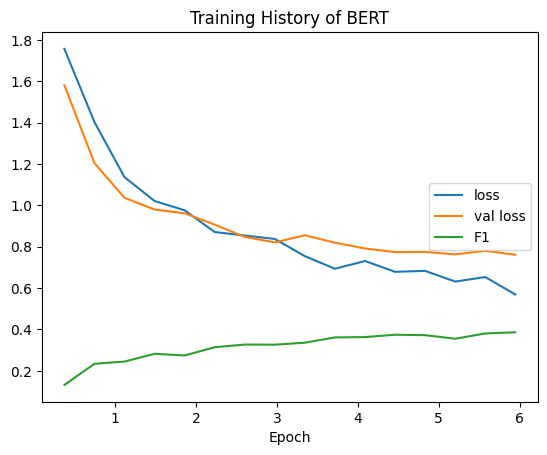

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epoch,loss,label='loss')
plt.plot(epoch,val_loss,label='val loss')
#plt.plot(epoch,list(map(lambda x: x/val_loss[0],learning_rate)),label='learning rate')
plt.plot(epoch,f1,label='F1')
plt.legend(loc='center right')
plt.title('Training History of BERT')
plt.xlabel('Epoch')

In [ ]:
trainer.save_model("/content/drive/My Drive/model_relations_luke")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch.nn.functional as F

def predict(text, entity_spans, model=trainer.model, tokenizer=tokenizer, device="cpu"):
    """Predict on new example"""
    inputs = tokenizer(text, entity_spans=entity_spans, return_tensors="pt").to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    return id2label[predicted_class_idx]

In [ ]:
text = "The x-ray showed a fracture."
entity_spans = [(4, 8), (19, 26)] # "x-ray", "fracture"
predict(text, entity_spans)

'TeRP'